## Cookbook: Parallelized *STRUCTURE* analyses on unlinked SNPs

As part of the `ipyrad.analysis` toolkit we've created convenience functions for easily distributing *STRUCTURE* analysis jobs on an HPC cluster, and for doing so in a programmatic and reproducible way. Importantly, *our workflow allows you to easily sample different distributions of unlinked SNPs among replicate analyses*, with the final inferred population structure summarized from a distribution of replicates. We also provide some simple interactive plotting functions to make barplots and slightly fancier figure, like below. 

### A note on Jupyter/IPython
This is a Jupyter notebook, a reproducible and executable document. The code in this notebook is Python (2.7), and should be executed either in a jupyter-notebook, like this one, or in an IPython terminal. Execute each cell in order to reproduce our entire analysis. We make use of the `ipyparallel` Python library to distribute *STRUCTURE* jobs across processers in parallel. If that is confusing, see our [tutorial on using ipcluster with jupyter](). The example data set used in this analysis is from the [empirical example ipyrad tutorial](http://ipyrad.readthedocs.io/pedicularis_.html).

### Required software
You can easily install the required software for this notebook locally using `conda` by running the commented code below in a terminal. If you are working on an HPC cluster you **do not need** administrator privileges to install the software in this way, since it is only installed locally.

In [1]:
## conda install ipyrad -c ipyrad
## conda install structure -c ipyrad
## conda install clumpp -c ipyrad
## conda install toytree -c eaton-lab

### Import Python libraries

In [1]:
import ipyrad.analysis as ipa      ## ipyrad analysis toolkit
import ipyparallel as ipp          ## parallel processing
import toyplot                     ## plotting library

### Parallel cluster setup
Start an `ipcluster` instance in a separate terminal. An easy way to do this in a jupyter-notebook running on an HPC cluster is to go to your Jupyter dashboard, and click [new], and then [terminal], and run `ipcluster start` in that terminal. This will start a local cluster on the compute node you are connected to. See our [ipyparallel tutorial] (coming soon) for further details. 

In [3]:
##
## ipcluster start --n=40
##

In [4]:
## get parallel client
ipyclient = ipp.Client()
print "Connected to {} cores".format(len(ipyclient))

Connected to 40 cores


### Enter input and output file locations

In [5]:
## the structure formatted file
strfile = "./analysis-ipyrad/pedicularis_outfiles/pedicularis.str"

## an optional mapfile, to sample unlinked SNPs
mapfile = "./analysis-ipyrad/pedicularis_outfiles/pedicularis.snps.map"

## the directory where outfiles should be written
workdir = "./analysis-structure/"

### Create a *Structure* Class object
Structure is kind of an old fashioned program that requires creating quite a few input files to run, which makes it not very convenient to use in a programmatic and reproducible way. To work around this we've created a convenience wrapper object to make it easy to submit Structure jobs and to summarize their results. 

In [6]:
## create a Structure object
struct = ipa.structure(name="test-1",
                       strfile=strfile, 
                       mapfile=mapfile,
                       workdir=workdir)

### Set parameter options for this object
Our Structure object will be used to submit jobs to the cluster. It has associated with it a name, a set of input files, and a large number of parameter settings. You can modify the parameters by setting them like below. You can also use tab-completion to see all of the available options, or print them like below. See the [full structure docs here](http://computing.bio.cam.ac.uk/local/doc/structure.pdf) for further details on the function of each parameter. In support of reproducibility, it is good practice to print both the mainparams and extraparams so it is clear which options you used. 

In [7]:
## set mainparams for object (you should run longer!)
struct.mainparams.burnin = 2000
struct.mainparams.numreps = 20000

## see all mainparams
print struct.mainparams

## see or set extraparams
print struct.extraparams

burnin               2000
extracols            0
label                1
locdata              0
mapdistances         0
markernames          0
markovphase          0
missing              -9
notambiguous         -999
numreps              20000
onerowperind         0
phased               0
phaseinfo            0
phenotype            0
ploidy               2
popdata              0
popflag              0
recessivealleles     0

admburnin            500
alpha                1.0
alphamax             10.0
alphapriora          1.0
alphapriorb          2.0
alphapropsd          0.025
ancestdist           0
ancestpint           0.9
computeprob          1
echodata             0
fpriormean           0.01
fpriorsd             0.05
freqscorr            1
gensback             2
inferalpha           1
inferlambda          0
intermedsave         0
lambda_              1.0
linkage              0
locispop             0
locprior             0
locpriorinit         1.0
log10rmax            1.0
log10rmin       

### Submit jobs to run on the cluster
The function `submit_structure_jobs()` distributes jobs to run on the cluster and load-balances the parallel workload. It takes a number of arguments. The first, `kpop`, is the number of populations. The second, `nreps`, is the number of replicated runs to perform. Each rep has a different random seed, and if you entered a mapfile for your Structure object then it will subsample unlinked snps independently in each replicate. The `seed` argument can be used to make the replicate analyses reproducible. The `extraparams.seed` parameter will be generated from this for each replicate. And finally, provide it the `ipyclient` object that we created above. The structure object will store an *asynchronous results object* for each job that is submitted so that we can query whether the jobs are finished yet or not. Using a simple for-loop we'll submit 20 replicate jobs to run at four different values of K. 

In [8]:
## a range of K-values to test
tests = [3, 4, 5, 6]

In [9]:
## submit batches of 20 replicate jobs for each value of K 
for kpop in tests:
    struct.submit_structure_jobs(kpop=kpop, 
                                 nreps=5, 
                                 seed=12345,
                                 ipyclient=ipyclient)

submitted 5 structure jobs [test-1-K-3]
submitted 5 structure jobs [test-1-K-4]
submitted 5 structure jobs [test-1-K-5]
submitted 5 structure jobs [test-1-K-6]


### Track progress until finished
You can check for finished results by using the `get_clumpp()` function, which tries to summarize the finished results files. If no results are ready it will simply print a warning message telling you to wait. If you want the notebook to block/wait until all jobs are finished then execute the `wait()` function of the ipyclient object, like below. 

In [15]:
## see submitted jobs
struct.asyncs

[<AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>,
 <AsyncResult: _call_structure>]

In [17]:
## query a job result
if struct.asyncs[0].ready():
    print struct.asyncs[0].result()

In [ ]:
## block/wait until all jobs finished
ipyclient.wait() 

### Summarize replicates with CLUMPP
We ran 20 replicates per K-value hypothesis. We now need to concatenate and purmute those results so they can be summarized. For this we use the software clumpp. The default arguments to clumpp are generally good, but you can modify them the same as structure params, by accessing the `.clumppparams` attribute of your structure object. See the [clumpp documentation](https://web.stanford.edu/group/rosenberglab/software/CLUMPP_Manual.pdf) for more details. If you have a large number of samples (>50) you may wish to use the `largeKgreedy` algorithm (m=3) for faster runtimes. Below we run clumpp for each value of K that we ran structure on. You only need to tell the `get_clumpp_table()` function the value of K and it will find all of the result files given the Structure object's `name` and `workdir`.

In [9]:
## set some clumpp params
struct.clumppparams.m = 3               ## use largegreedy algorithm
struct.clumppparams.greedy_option = 1   ## test all possible orders
struct.clumppparams

datatype                  0
every_permfile            0
greedy_option             1
indfile                   0
m                         3
miscfile                  0
order_by_run              1
outfile                   0
override_warnings         0
permfile                  0
permutationsfile          0
permuted_datafile         0
popfile                   0
print_every_perm          0
print_permuted_data       0
print_random_inputorder   0
random_inputorderfile     0
repeats                   1000
s                         2
w                         1

In [10]:
## run clumpp for each value of K
tables = {}
for kpop in tests:
    tables[kpop] = struct.get_clumpp_table(kpop)

mean scores across 5 replicates.
mean scores across 5 replicates.
mean scores across 5 replicates.
mean scores across 5 replicates.


### Sort the table order how you like it
This can be useful if, for example, you want to order the names to be in the same order as tips on your phylogeny. 

In [13]:
## custom sorting order
myorder = [
    "32082_przewalskii", 
    "33588_przewalskii",
    "41478_cyathophylloides", 
    "41954_cyathophylloides", 
    "29154_superba",
    "30686_cyathophylla", 
    "33413_thamno", 
    "30556_thamno", 
    "35236_rex", 
    "40578_rex", 
    "35855_rex",
    "39618_rex", 
    "38362_rex",
]

print "custom ordering"
print tables[5].ix[myorder]

custom ordering
                          0          1      2      3      4
32082_przewalskii       1.0  0.000e+00  0.000  0.000  0.000
33588_przewalskii       1.0  0.000e+00  0.000  0.000  0.000
41478_cyathophylloides  0.0  0.000e+00  1.000  0.000  0.000
41954_cyathophylloides  0.0  2.000e-04  1.000  0.000  0.000
29154_superba           0.0  7.931e-01  0.207  0.000  0.000
30686_cyathophylla      0.0  5.080e-01  0.247  0.002  0.243
33413_thamno            0.0  1.780e-02  0.000  0.619  0.363
30556_thamno            0.0  1.166e-01  0.000  0.676  0.207
35236_rex               0.0  1.884e-01  0.000  0.658  0.154
40578_rex               0.0  8.360e-02  0.000  0.776  0.141
35855_rex               0.0  8.020e-02  0.000  0.785  0.134
39618_rex               0.0  0.000e+00  0.000  1.000  0.000
38362_rex               0.0  0.000e+00  0.000  1.000  0.000


### A function for adding an interactive hover to our plots
The function automatically parses the table above for you. It can reorder the individuals based on their membership in each group, or based on an input list of ordered names. It returns the table of data as well as a list with information for making interactive hover boxes, which you can see below by hovering over the plots.  

In [14]:
def hover(table):
    hover = []
    for row in range(table.shape[0]):
        stack = []
        for col in range(table.shape[1]):
            label = "Name: {}\nGroup: {}\nProp: {}"\
                .format(table.index[row], 
                        table.columns[col],
                        table.ix[row, col])
            stack.append(label)
        hover.append(stack)
    return list(hover)

### Visualize population structure in barplots 
Hover over the plot to see sample names and info in the hover box. 

In [15]:
for kpop in tests:
    ## parse outfile to a table and re-order it
    table = tables[kpop]
    table = table.ix[myorder]
    
    ## plot barplot w/ hover
    canvas, axes, mark = toyplot.bars(
                            table, 
                            title=hover(table),
                            width=400, 
                            height=200, 
                            yshow=False,                            
                            style={"stroke": toyplot.color.near_black},
                            )


Name: 32082_przewalskii
Group: 0
Prop: 1.0 Name: 33588_przewalskii
Group: 0
Prop: 1.0 Name: 41478_cyathophylloides
Group: 0
Prop: 0.0 Name: 41954_cyathophylloides
Group: 0
Prop: 0.0 Name: 29154_superba
Group: 0
Prop: 0.1519 Name: 30686_cyathophylla
Group: 0
Prop: 0.1373 Name: 33413_thamno
Group: 0
Prop: 0.0664 Name: 30556_thamno
Group: 0
Prop: 0.049 Name: 35236_rex
Group: 0
Prop: 0.0568 Name: 40578_rex
Group: 0
Prop: 0.0228 Name: 35855_rex
Group: 0
Prop: 0.019 Name: 39618_rex
Group: 0
Prop: 0.0 Name: 38362_rex
Group: 0
Prop: 0.0 Name: 32082_przewalskii
Group: 1
Prop: 0.0 Name: 33588_przewalskii
Group: 1
Prop: 0.0 Name: 41478_cyathophylloides
Group: 1
Prop: 0.0 Name: 41954_cyathophylloides
Group: 1
Prop: 0.0 Name: 29154_superba
Group: 1
Prop: 0.058 Name: 30686_cyathophylla
Group: 1
Prop: 0.0607 Name: 33413_thamno
Group: 1
Prop: 0.9336 Name: 30556_thamno
Group: 1
Prop: 0.951 Name: 35236_rex
Group: 1
Prop: 0.9432 Name: 40578_rex
Group: 1
Prop: 0.9772 Name: 35855_rex
Group: 1
Prop: 0.981 Name: 39618_rex
Group: 1
Prop: 1.0 Name: 38362_rex
Group: 1
Prop: 1.0 Name: 32082_przewalskii
Group: 2
Prop: 0.0 Name: 33588_przewalskii
Group: 2
Prop: 0.0 Name: 41478_cyathophylloides
Group: 2
Prop: 1.0 Name: 41954_cyathophylloides
Group: 2
Prop: 1.0 Name: 29154_superba
Group: 2
Prop: 0.7901 Name: 30686_cyathophylla
Group: 2
Prop: 0.802 Name: 33413_thamno
Group: 2
Prop: 0.0 Name: 30556_thamno
Group: 2
Prop: 0.0 Name: 35236_rex
Group: 2
Prop: 0.0 Name: 40578_rex
Group: 2
Prop: 0.0 Name: 35855_rex
Group: 2
Prop: 0.0 Name: 39618_rex
Group: 2
Prop: 0.0 Name: 38362_rex
Group: 2
Prop: 0.0 0 4 8 12 
 
 
 Save as .csv

Name: 32082_przewalskii
Group: 0
Prop: 0.0 Name: 33588_przewalskii
Group: 0
Prop: 0.0 Name: 41478_cyathophylloides
Group: 0
Prop: 1.0 Name: 41954_cyathophylloides
Group: 0
Prop: 1.0 Name: 29154_superba
Group: 0
Prop: 0.3113 Name: 30686_cyathophylla
Group: 0
Prop: 0.3451 Name: 33413_thamno
Group: 0
Prop: 0.0 Name: 30556_thamno
Group: 0
Prop: 0.0 Name: 35236_rex
Group: 0
Prop: 0.0 Name: 40578_rex
Group: 0
Prop: 0.0 Name: 35855_rex
Group: 0
Prop: 0.0 Name: 39618_rex
Group: 0
Prop: 0.0 Name: 38362_rex
Group: 0
Prop: 0.0 Name: 32082_przewalskii
Group: 1
Prop: 0.0 Name: 33588_przewalskii
Group: 1
Prop: 0.0 Name: 41478_cyathophylloides
Group: 1
Prop: 0.0 Name: 41954_cyathophylloides
Group: 1
Prop: 0.0 Name: 29154_superba
Group: 1
Prop: 0.003 Name: 30686_cyathophylla
Group: 1
Prop: 0.0114 Name: 33413_thamno
Group: 1
Prop: 0.6608 Name: 30556_thamno
Group: 1
Prop: 0.7294 Name: 35236_rex
Group: 1
Prop: 0.7075 Name: 40578_rex
Group: 1
Prop: 0.827 Name: 35855_rex
Group: 1
Prop: 0.8388 Name: 39618_rex
Group: 1
Prop: 1.0 Name: 38362_rex
Group: 1
Prop: 1.0 Name: 32082_przewalskii
Group: 2
Prop: 1.0 Name: 33588_przewalskii
Group: 2
Prop: 1.0 Name: 41478_cyathophylloides
Group: 2
Prop: 0.0 Name: 41954_cyathophylloides
Group: 2
Prop: 0.0 Name: 29154_superba
Group: 2
Prop: 0.031 Name: 30686_cyathophylla
Group: 2
Prop: 0.0328 Name: 33413_thamno
Group: 2
Prop: 0.002 Name: 30556_thamno
Group: 2
Prop: 0.0 Name: 35236_rex
Group: 2
Prop: 0.0134 Name: 40578_rex
Group: 2
Prop: 0.0018 Name: 35855_rex
Group: 2
Prop: 0.0026 Name: 39618_rex
Group: 2
Prop: 0.0 Name: 38362_rex
Group: 2
Prop: 0.0 Name: 32082_przewalskii
Group: 3
Prop: 0.0 Name: 33588_przewalskii
Group: 3
Prop: 0.0 Name: 41478_cyathophylloides
Group: 3
Prop: 0.0 Name: 41954_cyathophylloides
Group: 3
Prop: 0.0 Name: 29154_superba
Group: 3
Prop: 0.6547 Name: 30686_cyathophylla
Group: 3
Prop: 0.6107 Name: 33413_thamno
Group: 3
Prop: 0.3372 Name: 30556_thamno
Group: 3
Prop: 0.2706 Name: 35236_rex
Group: 3
Prop: 0.2791 Name: 40578_rex
Group: 3
Prop: 0.1712 Name: 35855_rex
Group: 3
Prop: 0.1586 Name: 39618_rex
Group: 3
Prop: 0.0 Name: 38362_rex
Group: 3
Prop: 0.0 0 4 8 12 
 
 
 Save as .csv

Name: 32082_przewalskii
Group: 0
Prop: 1.0 Name: 33588_przewalskii
Group: 0
Prop: 1.0 Name: 41478_cyathophylloides
Group: 0
Prop: 0.0 Name: 41954_cyathophylloides
Group: 0
Prop: 0.0 Name: 29154_superba
Group: 0
Prop: 0.0 Name: 30686_cyathophylla
Group: 0
Prop: 0.0 Name: 33413_thamno
Group: 0
Prop: 0.0 Name: 30556_thamno
Group: 0
Prop: 0.0 Name: 35236_rex
Group: 0
Prop: 0.0 Name: 40578_rex
Group: 0
Prop: 0.0 Name: 35855_rex
Group: 0
Prop: 0.0 Name: 39618_rex
Group: 0
Prop: 0.0 Name: 38362_rex
Group: 0
Prop: 0.0 Name: 32082_przewalskii
Group: 1
Prop: 0.0 Name: 33588_przewalskii
Group: 1
Prop: 0.0 Name: 41478_cyathophylloides
Group: 1
Prop: 0.0 Name: 41954_cyathophylloides
Group: 1
Prop: 0.0002 Name: 29154_superba
Group: 1
Prop: 0.7931 Name: 30686_cyathophylla
Group: 1
Prop: 0.508 Name: 33413_thamno
Group: 1
Prop: 0.0178 Name: 30556_thamno
Group: 1
Prop: 0.1166 Name: 35236_rex
Group: 1
Prop: 0.1884 Name: 40578_rex
Group: 1
Prop: 0.0836 Name: 35855_rex
Group: 1
Prop: 0.0802 Name: 39618_rex
Group: 1
Prop: 0.0 Name: 38362_rex
Group: 1
Prop: 0.0 Name: 32082_przewalskii
Group: 2
Prop: 0.0 Name: 33588_przewalskii
Group: 2
Prop: 0.0 Name: 41478_cyathophylloides
Group: 2
Prop: 1.0 Name: 41954_cyathophylloides
Group: 2
Prop: 0.9998 Name: 29154_superba
Group: 2
Prop: 0.2069 Name: 30686_cyathophylla
Group: 2
Prop: 0.2466 Name: 33413_thamno
Group: 2
Prop: 0.0 Name: 30556_thamno
Group: 2
Prop: 0.0 Name: 35236_rex
Group: 2
Prop: 0.0 Name: 40578_rex
Group: 2
Prop: 0.0 Name: 35855_rex
Group: 2
Prop: 0.0 Name: 39618_rex
Group: 2
Prop: 0.0 Name: 38362_rex
Group: 2
Prop: 0.0 Name: 32082_przewalskii
Group: 3
Prop: 0.0 Name: 33588_przewalskii
Group: 3
Prop: 0.0 Name: 41478_cyathophylloides
Group: 3
Prop: 0.0 Name: 41954_cyathophylloides
Group: 3
Prop: 0.0 Name: 29154_superba
Group: 3
Prop: 0.0 Name: 30686_cyathophylla
Group: 3
Prop: 0.002 Name: 33413_thamno
Group: 3
Prop: 0.6187 Name: 30556_thamno
Group: 3
Prop: 0.6761 Name: 35236_rex
Group: 3
Prop: 0.6578 Name: 40578_rex
Group: 3
Prop: 0.7756 Name: 35855_rex
Group: 3
Prop: 0.7854 Name: 39618_rex
Group: 3
Prop: 1.0 Name: 38362_rex
Group: 3
Prop: 1.0 Name: 32082_przewalskii
Group: 4
Prop: 0.0 Name: 33588_przewalskii
Group: 4
Prop: 0.0 Name: 41478_cyathophylloides
Group: 4
Prop: 0.0 Name: 41954_cyathophylloides
Group: 4
Prop: 0.0 Name: 29154_superba
Group: 4
Prop: 0.0 Name: 30686_cyathophylla
Group: 4
Prop: 0.2434 Name: 33413_thamno
Group: 4
Prop: 0.3635 Name: 30556_thamno
Group: 4
Prop: 0.2072 Name: 35236_rex
Group: 4
Prop: 0.1538 Name: 40578_rex
Group: 4
Prop: 0.1408 Name: 35855_rex
Group: 4
Prop: 0.1344 Name: 39618_rex
Group: 4
Prop: 0.0 Name: 38362_rex
Group: 4
Prop: 0.0 0 4 8 12 
 
 
 Save as .csv

Name: 32082_przewalskii
Group: 0
Prop: 0.0 Name: 33588_przewalskii
Group: 0
Prop: 0.0 Name: 41478_cyathophylloides
Group: 0
Prop: 0.0 Name: 41954_cyathophylloides
Group: 0
Prop: 0.0 Name: 29154_superba
Group: 0
Prop: 0.0 Name: 30686_cyathophylla
Group: 0
Prop: 0.3835 Name: 33413_thamno
Group: 0
Prop: 0.0 Name: 30556_thamno
Group: 0
Prop: 0.1839 Name: 35236_rex
Group: 0
Prop: 0.09 Name: 40578_rex
Group: 0
Prop: 0.0402 Name: 35855_rex
Group: 0
Prop: 0.1362 Name: 39618_rex
Group: 0
Prop: 0.0 Name: 38362_rex
Group: 0
Prop: 0.0 Name: 32082_przewalskii
Group: 1
Prop: 1.0 Name: 33588_przewalskii
Group: 1
Prop: 1.0 Name: 41478_cyathophylloides
Group: 1
Prop: 0.0 Name: 41954_cyathophylloides
Group: 1
Prop: 0.0 Name: 29154_superba
Group: 1
Prop: 0.0 Name: 30686_cyathophylla
Group: 1
Prop: 0.0078 Name: 33413_thamno
Group: 1
Prop: 0.0 Name: 30556_thamno
Group: 1
Prop: 0.0 Name: 35236_rex
Group: 1
Prop: 0.0 Name: 40578_rex
Group: 1
Prop: 0.0 Name: 35855_rex
Group: 1
Prop: 0.0014 Name: 39618_rex
Group: 1
Prop: 0.0 Name: 38362_rex
Group: 1
Prop: 0.0 Name: 32082_przewalskii
Group: 2
Prop: 0.0 Name: 33588_przewalskii
Group: 2
Prop: 0.0 Name: 41478_cyathophylloides
Group: 2
Prop: 1.0 Name: 41954_cyathophylloides
Group: 2
Prop: 1.0 Name: 29154_superba
Group: 2
Prop: 0.2183 Name: 30686_cyathophylla
Group: 2
Prop: 0.2431 Name: 33413_thamno
Group: 2
Prop: 0.0 Name: 30556_thamno
Group: 2
Prop: 0.0014 Name: 35236_rex
Group: 2
Prop: 0.0 Name: 40578_rex
Group: 2
Prop: 0.0 Name: 35855_rex
Group: 2
Prop: 0.0 Name: 39618_rex
Group: 2
Prop: 0.0 Name: 38362_rex
Group: 2
Prop: 0.0 Name: 32082_przewalskii
Group: 3
Prop: 0.0 Name: 33588_przewalskii
Group: 3
Prop: 0.0 Name: 41478_cyathophylloides
Group: 3
Prop: 0.0 Name: 41954_cyathophylloides
Group: 3
Prop: 0.0 Name: 29154_superba
Group: 3
Prop: 0.0 Name: 30686_cyathophylla
Group: 3
Prop: 0.0048 Name: 33413_thamno
Group: 3
Prop: 0.6283 Name: 30556_thamno
Group: 3
Prop: 0.6905 Name: 35236_rex
Group: 3
Prop: 0.6763 Name: 40578_rex
Group: 3
Prop: 0.8006 Name: 35855_rex
Group: 3
Prop: 0.8124 Name: 39618_rex
Group: 3
Prop: 0.9882 Name: 38362_rex
Group: 3
Prop: 0.9912 Name: 32082_przewalskii
Group: 4
Prop: 0.0 Name: 33588_przewalskii
Group: 4
Prop: 0.0 Name: 41478_cyathophylloides
Group: 4
Prop: 0.0 Name: 41954_cyathophylloides
Group: 4
Prop: 0.0 Name: 29154_superba
Group: 4
Prop: 0.7793 Name: 30686_cyathophylla
Group: 4
Prop: 0.338 Name: 33413_thamno
Group: 4
Prop: 0.1121 Name: 30556_thamno
Group: 4
Prop: 0.0274 Name: 35236_rex
Group: 4
Prop: 0.168 Name: 40578_rex
Group: 4
Prop: 0.0412 Name: 35855_rex
Group: 4
Prop: 0.0162 Name: 39618_rex
Group: 4
Prop: 0.0118 Name: 38362_rex
Group: 4
Prop: 0.0088 Name: 32082_przewalskii
Group: 5
Prop: 0.0 Name: 33588_przewalskii
Group: 5
Prop: 0.0 Name: 41478_cyathophylloides
Group: 5
Prop: 0.0 Name: 41954_cyathophylloides
Group: 5
Prop: 0.0 Name: 29154_superba
Group: 5
Prop: 0.0024 Name: 30686_cyathophylla
Group: 5
Prop: 0.0228 Name: 33413_thamno
Group: 5
Prop: 0.2596 Name: 30556_thamno
Group: 5
Prop: 0.0968 Name: 35236_rex
Group: 5
Prop: 0.0657 Name: 40578_rex
Group: 5
Prop: 0.118 Name: 35855_rex
Group: 5
Prop: 0.0338 Name: 39618_rex
Group: 5
Prop: 0.0 Name: 38362_rex
Group: 5
Prop: 0.0 0 4 8 12 
 
 
 Save as .csv

### Make a slightly fancier plot and save to file

In [16]:
## save plots for your favorite value of K
table = struct.get_clumpp_table(kpop=5)
table = table.ix[myorder]

mean scores across 5 replicates.


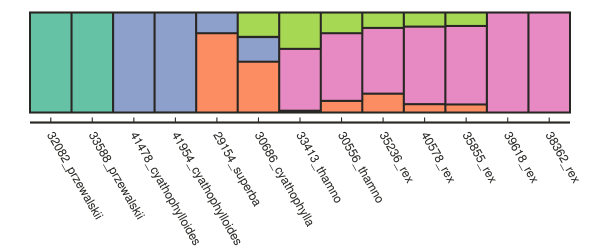

In [24]:
## further styling of plot with css 
style = {"stroke":toyplot.color.near_black, 
         "stroke-width": 2}

## build barplot
canvas = toyplot.Canvas(width=600, height=250)
axes = canvas.cartesian(bounds=("5%", "95%", "5%", "45%"))
axes.bars(table, title=hover(table), style=style)

## add names to x-axis
ticklabels = [i for i in table.index.tolist()]
axes.x.ticks.locator = toyplot.locator.Explicit(labels=ticklabels)
axes.x.ticks.labels.angle = -60
axes.x.ticks.show = True
axes.x.ticks.labels.offset = 10
axes.x.ticks.labels.style = {"font-size": "12px"}
axes.x.spine.style = style
axes.y.show = False
    
## options: uncomment to save plots. Only html retains hover.
import toyplot.svg
import toyplot.pdf
import toyplot.html
toyplot.svg.render(canvas, "struct.svg")
toyplot.pdf.render(canvas, "struct.pdf")
toyplot.html.render(canvas, "struct.html")

## show in notebook
canvas

### Calculating the best K 
I haven't gotten around to writing the code for this yet (contributors are welcome!). For now, I like using the site http://taylor0.biology.ucla.edu/structureHarvester/. It's great. Super easy. Zip up all the files in our structure directory, submit them to the site, and you're done. 

In [165]:
%%bash -s "$STRUCTDIR"

## creates zip dir of all files ending with _f
zip $1/structure-files.zip $1/*_f

updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-3-rep-0_f (deflated 82%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-3-rep-1_f (deflated 82%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-3-rep-2_f (deflated 81%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-3-rep-3_f (deflated 82%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-3-rep-4_f (deflated 82%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-4-rep-0_f (deflated 80%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-4-rep-1_f (deflated 80%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-4-rep-2_f (deflated 80%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-4-rep-3_f (deflated 81%)
updating: home/deren/Documents/ipyrad/tests/analysis_structure/K-4-rep-4_f (deflated 80%)
  adding: home/deren/Documents/ipyrad/tests/analysis_structure/K-5-rep-0_f (deflated 80%)
  adding: 

### Copying this notebook to your computer/cluster
You can easily copy this notebook and then just replace my file names with your filenames to run your analysis. Just click on the [Download Notebook] link at the top of this page. Then run `jupyter-notebook` from a terminal and open this notebook from the dashboard.